In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#set engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#reflect database
Base = automap_base()
#reflect tables
Base.prepare(engine, reflect=True)

In [7]:
# Saving tables

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Session creation

session = Session(engine)

# Exploratory Climate Analysis

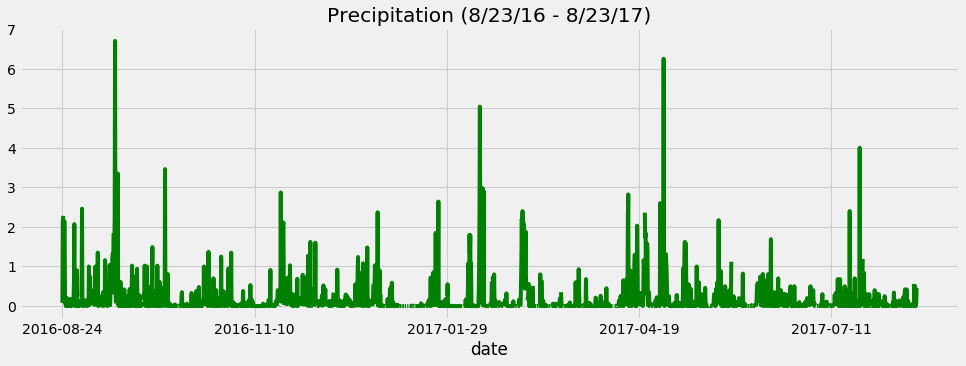

In [9]:
# Finding latest dates

latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

latestDate = list(np.ravel(latestDate))[0]

latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

# The latest year as integer

latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

# Subtract 365 for year before
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

# Latest year for precipitation

rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

# Date sorting

rainTable = rainTable.sort_index(ascending=True)

# Pandas plot of precipitation for the year

rainTable.plot(title="Precipitation (8/23/16 - 8/23/17)",legend=False,figsize=(15,5),color="g")

In [10]:
# Displya of data statistics

rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Station count

stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [12]:
# Observations per station

stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Most active station

stationID = stationCounts[0][0]

# Most active station name

stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"Most active station is {stationID}: {stationName}.")

# Highest temp

highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"Highest temp recorded there is {highestTemp} Farenheit.")

# Lowest temp

lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"Lowest temp is {lowestTemp} Farenheit.")

# Average temp

avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"Average temp recorded there is {avgTemp} Farenheit.")

Most active station is USC00519281: WAIHEE 837.5, HI US.
Highest temp recorded there is 85.0 Farenheit.
Lowest temp is 54.0 Farenheit.
Average temp recorded there is 71.7 Farenheit.


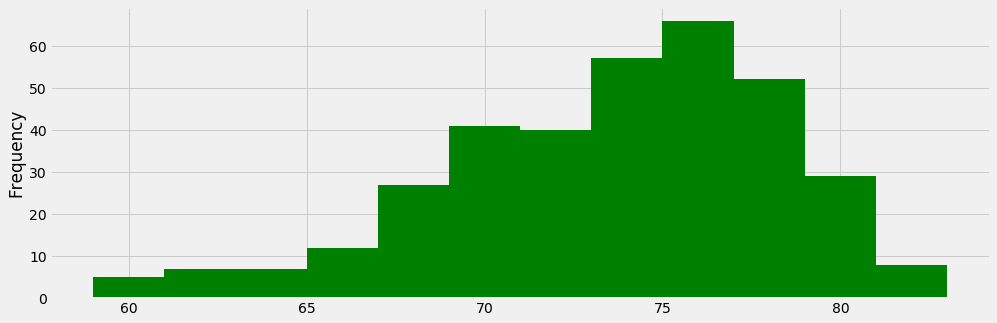

In [14]:
# Last year temp data

tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

# Date sort

tempTable = tempTable.sort_index(ascending=True)

# Pandas plot

tempTable.plot(kind='hist',bins=12,legend=False,figsize=(15,5),color="g")

# Bonus Challenge Assignment

In [15]:
# Function takes a start date and end date giving the min, avg, and max temp 

def calc_tempstats(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Temps for given date range

print(calc_tempstats('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
#set trip dates and previous dates
trip = '2019-04-08 to \n 2019-04-19'
tripStartDate = '2017-04-08'
tripEndDate = '2017-04-19'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_tempstats(tripStartDate, tripEndDate)

tripTemps

[(67.0, 73.6, 83.0)]

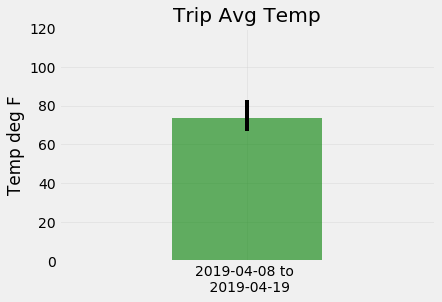

In [17]:
# Average temp for trip with error 

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'green', alpha = .6)
plt.ylim(0, 120)
plt.xlim(-1.0, 1.0)
plt.title('Trip Avg Temp')
plt.ylabel('Temp deg F')
plt.grid(alpha=.3)

In [18]:
# Precip desc order per station

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

stationRainTable = pd.DataFrame(np.array(stationRain))

stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Tot. Precip.", 3: "Lat", 
                                                    4: "Lon", 5: "Elevation"})

stationRainTable

,Station,Location,Tot. Precip.,Lat,Lon,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# set the start and end date for the trip

startDate = "2019-03-01"
endDate = "2019-03-12"

# calculate trip length

startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# start date as datetime object

startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

# list dates (MM-DD) of trip

dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

# calculate normals for each date

tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)],
 [(60.0, 69.89285714285714, 82.0)],
 [(62.0, 69.88888888888889, 80.0)]]

In [21]:
# Use the start and end date to create a range of dates

tripNormals = [np.array(normal[0]) for normal in tripNormals]

normalsTable = pd.DataFrame(tripNormals)

# Add a col for Date

normalsTable["Date"] = dateList

# Rename col

normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


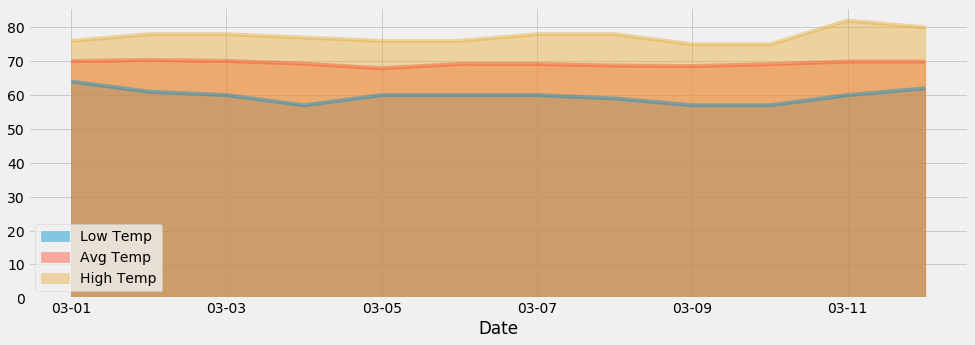

In [22]:
#plot Trend
normalsTable.plot.area(stacked=False, alpha=.444,figsize=(15,5))